<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>NLP with Deep Learning for Everyone</h1>
<h1>Foundations of NLP</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import gzip
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import string
import nltk
from nltk.corpus import stopwords  
from nltk.text import TextCollection
from nltk.collocations import BigramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures

import sklearn
from sklearn.manifold import TSNE

from tqdm import tqdm
tqdm.pandas()

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 3022f3d8aeb2c24ebf2d47d4e9999181a7ad777d

pandas    : 2.0.3
nltk      : 3.8.1
watermark : 2.4.3
sklearn   : 1.3.0
numpy     : 1.23.5
json      : 2.0.9
matplotlib: 3.7.2



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# One-Hot Encoding

In [4]:
text = """Mary had a little lamb, little lamb,
    little lamb. 'Mary' had a little lamb
    whose fleece was white as snow.
    And everywhere that Mary went
    Mary went, MARY went. Everywhere
    that mary went,
    The lamb was sure to go"""

The first step is to tokenize the text. NLTK provides us with a convenient tokenizer function we can use. It is also smart enough to be able to handle different languages. We start by making sure that we have the punkt add-on downloaded

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bgoncalves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

And then move on to using it to tokenize our text

In [6]:
tokens = nltk.word_tokenize(text, 'english')

In [7]:
pprint(tokens)

['Mary',
 'had',
 'a',
 'little',
 'lamb',
 ',',
 'little',
 'lamb',
 ',',
 'little',
 'lamb',
 '.',
 "'Mary",
 "'",
 'had',
 'a',
 'little',
 'lamb',
 'whose',
 'fleece',
 'was',
 'white',
 'as',
 'snow',
 '.',
 'And',
 'everywhere',
 'that',
 'Mary',
 'went',
 'Mary',
 'went',
 ',',
 'MARY',
 'went',
 '.',
 'Everywhere',
 'that',
 'mary',
 'went',
 ',',
 'The',
 'lamb',
 'was',
 'sure',
 'to',
 'go']


You'll note that NLTK includes apostrophes at the beginning of words and returns all punctuation markings.

In [8]:
print(tokens[5])
print(tokens[12])
print(tokens[13])

,
'Mary
'


We wrap it into a utility function to handle these

In [9]:
def tokenize(text, preserve_case=True):
    punctuation = set(string.punctuation)
    text_words = []
    
    for word in nltk.word_tokenize(text, 'english'):
        # Remove any punctuation characters present in the beginning of the word
        while len(word) > 0 and  word[0] in punctuation:
            word = word[1:]

        # Remove any punctuation characters present in the end of the word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]
        
        if len(word) > 0:
            if preserve_case:
                text_words.append(word)
            else:
                text_words.append(word.lower())
        
    return text_words

In [10]:
text_words = tokenize(text, preserve_case=False)

In [11]:
text_words

['mary',
 'had',
 'a',
 'little',
 'lamb',
 'little',
 'lamb',
 'little',
 'lamb',
 'mary',
 'had',
 'a',
 'little',
 'lamb',
 'whose',
 'fleece',
 'was',
 'white',
 'as',
 'snow',
 'and',
 'everywhere',
 'that',
 'mary',
 'went',
 'mary',
 'went',
 'mary',
 'went',
 'everywhere',
 'that',
 'mary',
 'went',
 'the',
 'lamb',
 'was',
 'sure',
 'to',
 'go']

We can get a quick one-hot encoded version using pandas:

In [12]:
one_hot = pd.get_dummies(text_words)

Which provides us with a DataFrame where each column corresponds to an individual unique word and each row to a word in our text.

In [13]:
temp = one_hot.astype('str')
temp[temp=='0'] = ""
temp = pd.DataFrame(temp)
temp

,a,and,as,everywhere,fleece,go,had,lamb,little,mary,snow,sure,that,the,to,was,went,white,whose
0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


From here can easily generate a mapping between the words and their numerical id

In [14]:
word_dict = dict(zip(one_hot.columns, np.arange(one_hot.shape[1])))
word_dict

{'a': 0,
 'and': 1,
 'as': 2,
 'everywhere': 3,
 'fleece': 4,
 'go': 5,
 'had': 6,
 'lamb': 7,
 'little': 8,
 'mary': 9,
 'snow': 10,
 'sure': 11,
 'that': 12,
 'the': 13,
 'to': 14,
 'was': 15,
 'went': 16,
 'white': 17,
 'whose': 18}

Allowing us to easily transform from words to ids and back

# Bag of Words

From the one-hot encoded representation we can easily obtain the bag of words version of our document

In [15]:
pd.DataFrame(one_hot.sum(), columns=['Count'])

,Count
a,2
and,1
as,1
everywhere,2
fleece,1
go,1
had,2
lamb,5
little,4
mary,6


In [16]:
Counter(text_words)

Counter({'mary': 6,
         'had': 2,
         'a': 2,
         'little': 4,
         'lamb': 5,
         'whose': 1,
         'fleece': 1,
         'was': 2,
         'white': 1,
         'as': 1,
         'snow': 1,
         'and': 1,
         'everywhere': 2,
         'that': 2,
         'went': 4,
         'the': 1,
         'sure': 1,
         'to': 1,
         'go': 1})

A more general representation would be to use a dictionary mapping each word to the number of times it occurs. This has the added advantage of being a dense representation that doesn't waste any space

# Stemming

In [17]:
words = ['playing', 'loved', 'ran', 'river', 'friendships', 
         'misunderstanding', 'trouble', 'troubling']

stemmers = { 
    'LancasterStemmer' : nltk.stem.LancasterStemmer(),
    'PorterStemmer' : nltk.stem.PorterStemmer(),
    'RegexpStemmer' : nltk.stem.RegexpStemmer('ing$|s$|e$|able$'),
    'SnowballStemmer' : nltk.stem.SnowballStemmer('english')
}

In [18]:
matrix = []

for word in words:
    row = []
    for stemmer in stemmers:
        stem = stemmers[stemmer]
        row.append(stem.stem(word))
        
    matrix.append(row)

comparison = pd.DataFrame(matrix, index=words, columns=stemmers.keys())

In [19]:
comparison

,LancasterStemmer,PorterStemmer,RegexpStemmer,SnowballStemmer
playing,play,play,play,play
loved,lov,love,loved,love
ran,ran,ran,ran,ran
river,riv,river,river,river
friendships,friend,friendship,friendship,friendship
misunderstanding,misunderstand,misunderstand,misunderstand,misunderstand
trouble,troubl,troubl,troubl,troubl
troubling,troubl,troubl,troubl,troubl


# Lemmatization

In [20]:
wordnet = nltk.stem.WordNetLemmatizer()

results_n = [wordnet.lemmatize(word, 'n') for word in words]
results_v = [wordnet.lemmatize(word, 'v') for word in words]

In [21]:
comparison['WordNetLemmatizer Noun'] = results_n
comparison['WordNetLemmatizer Verb'] = results_v

In [22]:
comparison

,LancasterStemmer,PorterStemmer,RegexpStemmer,SnowballStemmer,WordNetLemmatizer Noun,WordNetLemmatizer Verb
playing,play,play,play,play,playing,play
loved,lov,love,loved,love,loved,love
ran,ran,ran,ran,ran,ran,run
river,riv,river,river,river,river,river
friendships,friend,friendship,friendship,friendship,friendship,friendships
misunderstanding,misunderstand,misunderstand,misunderstand,misunderstand,misunderstanding,misunderstand
trouble,troubl,troubl,troubl,troubl,trouble,trouble
troubling,troubl,troubl,troubl,troubl,troubling,trouble


# Stopwords

NLTK provides stopwords for 23 different languages

In [23]:
os.listdir('/Users/bgoncalves/nltk_data/corpora/stopwords/')

['dutch',
 'german',
 'slovene',
 'hungarian',
 'romanian',
 'kazakh',
 'turkish',
 'russian',
 'README',
 'italian',
 'english',
 'greek',
 'tajik',
 'norwegian',
 'portuguese',
 'finnish',
 'danish',
 'french',
 'swedish',
 'azerbaijani',
 'spanish',
 'indonesian',
 'arabic',
 'nepali']

And we can easily use them to filter out meaningless words

In [24]:
stop_words = set(stopwords.words('english'))  
  
tokens = tokenize(text)  
  
filtered_sentence = [word if word.lower() not in stop_words else "" for word in tokens]  
  
pd.DataFrame((zip(tokens, filtered_sentence)), 
             columns=['Original', 'Filtered']).set_index('Original')

,Filtered
Original,
Mary,Mary
had,
a,
little,little
lamb,lamb
little,little
lamb,lamb
little,little
lamb,lamb


# N-Grams

In [25]:
def get_ngrams(text, length):
    from nltk.util import ngrams
    
    n_grams = ngrams(tokenize(text), length)
    return [' '.join(grams) for grams in n_grams]

In [26]:
get_ngrams(text.lower(), 2)

['mary had',
 'had a',
 'a little',
 'little lamb',
 'lamb little',
 'little lamb',
 'lamb little',
 'little lamb',
 'lamb mary',
 'mary had',
 'had a',
 'a little',
 'little lamb',
 'lamb whose',
 'whose fleece',
 'fleece was',
 'was white',
 'white as',
 'as snow',
 'snow and',
 'and everywhere',
 'everywhere that',
 'that mary',
 'mary went',
 'went mary',
 'mary went',
 'went mary',
 'mary went',
 'went everywhere',
 'everywhere that',
 'that mary',
 'mary went',
 'went the',
 'the lamb',
 'lamb was',
 'was sure',
 'sure to',
 'to go']

# Collocations

In [27]:
bigrams = BigramCollocationFinder.from_words(tokenize(text, False))
scored = bigrams.score_ngrams(BigramAssocMeasures.likelihood_ratio)

In [28]:
scored

[(('little', 'lamb'), 20.789064969512467),
 (('mary', 'went'), 18.154919185356587),
 (('everywhere', 'that'), 15.777294140200038),
 (('had', 'a'), 15.777294140200038),
 (('a', 'little'), 10.232116695720478),
 (('as', 'snow'), 9.301260258907092),
 (('snow', 'and'), 9.301260258907092),
 (('sure', 'to'), 9.301260258907092),
 (('to', 'go'), 9.301260258907092),
 (('white', 'as'), 9.301260258907092),
 (('whose', 'fleece'), 9.301260258907092),
 (('mary', 'had'), 8.139124120662284),
 (('that', 'mary'), 8.139124120662284),
 (('and', 'everywhere'), 6.528671536667327),
 (('fleece', 'was'), 6.528671536667327),
 (('was', 'sure'), 6.528671536667327),
 (('was', 'white'), 6.528671536667327),
 (('went', 'the'), 4.802579101956642),
 (('lamb', 'whose'), 4.297236023525216),
 (('the', 'lamb'), 4.297236023525216),
 (('lamb', 'little'), 3.850143362325084),
 (('went', 'mary'), 3.065215528887738),
 (('went', 'everywhere'), 2.196764352889584),
 (('lamb', 'was'), 1.7502532877068806),
 (('lamb', 'mary'), 0.088193

# TF-IDF

NLTK has the TextCollection object that allows us to easily compute tf-idf scores from a given corpus. We generate a small corpus by splitting our text by sentence

In [29]:
corpus = text.split('.')

We have 4 documents in our corpus

In [30]:
len(corpus)

4

NLTK expects the corpus to be tokenized so we do that now

In [31]:
corpus = [tokenize(doc, preserve_case=False) for doc in corpus]

In [32]:
corpus

[['mary', 'had', 'a', 'little', 'lamb', 'little', 'lamb', 'little', 'lamb'],
 ['mary',
  'had',
  'a',
  'little',
  'lamb',
  'whose',
  'fleece',
  'was',
  'white',
  'as',
  'snow'],
 ['and', 'everywhere', 'that', 'mary', 'went', 'mary', 'went', 'mary', 'went'],
 ['everywhere',
  'that',
  'mary',
  'went',
  'the',
  'lamb',
  'was',
  'sure',
  'to',
  'go']]

We initialize the TextCollection object with our corpus

In [33]:
nlp = TextCollection(corpus)

This object provides us with a great deal of functionality, like total frequency counts

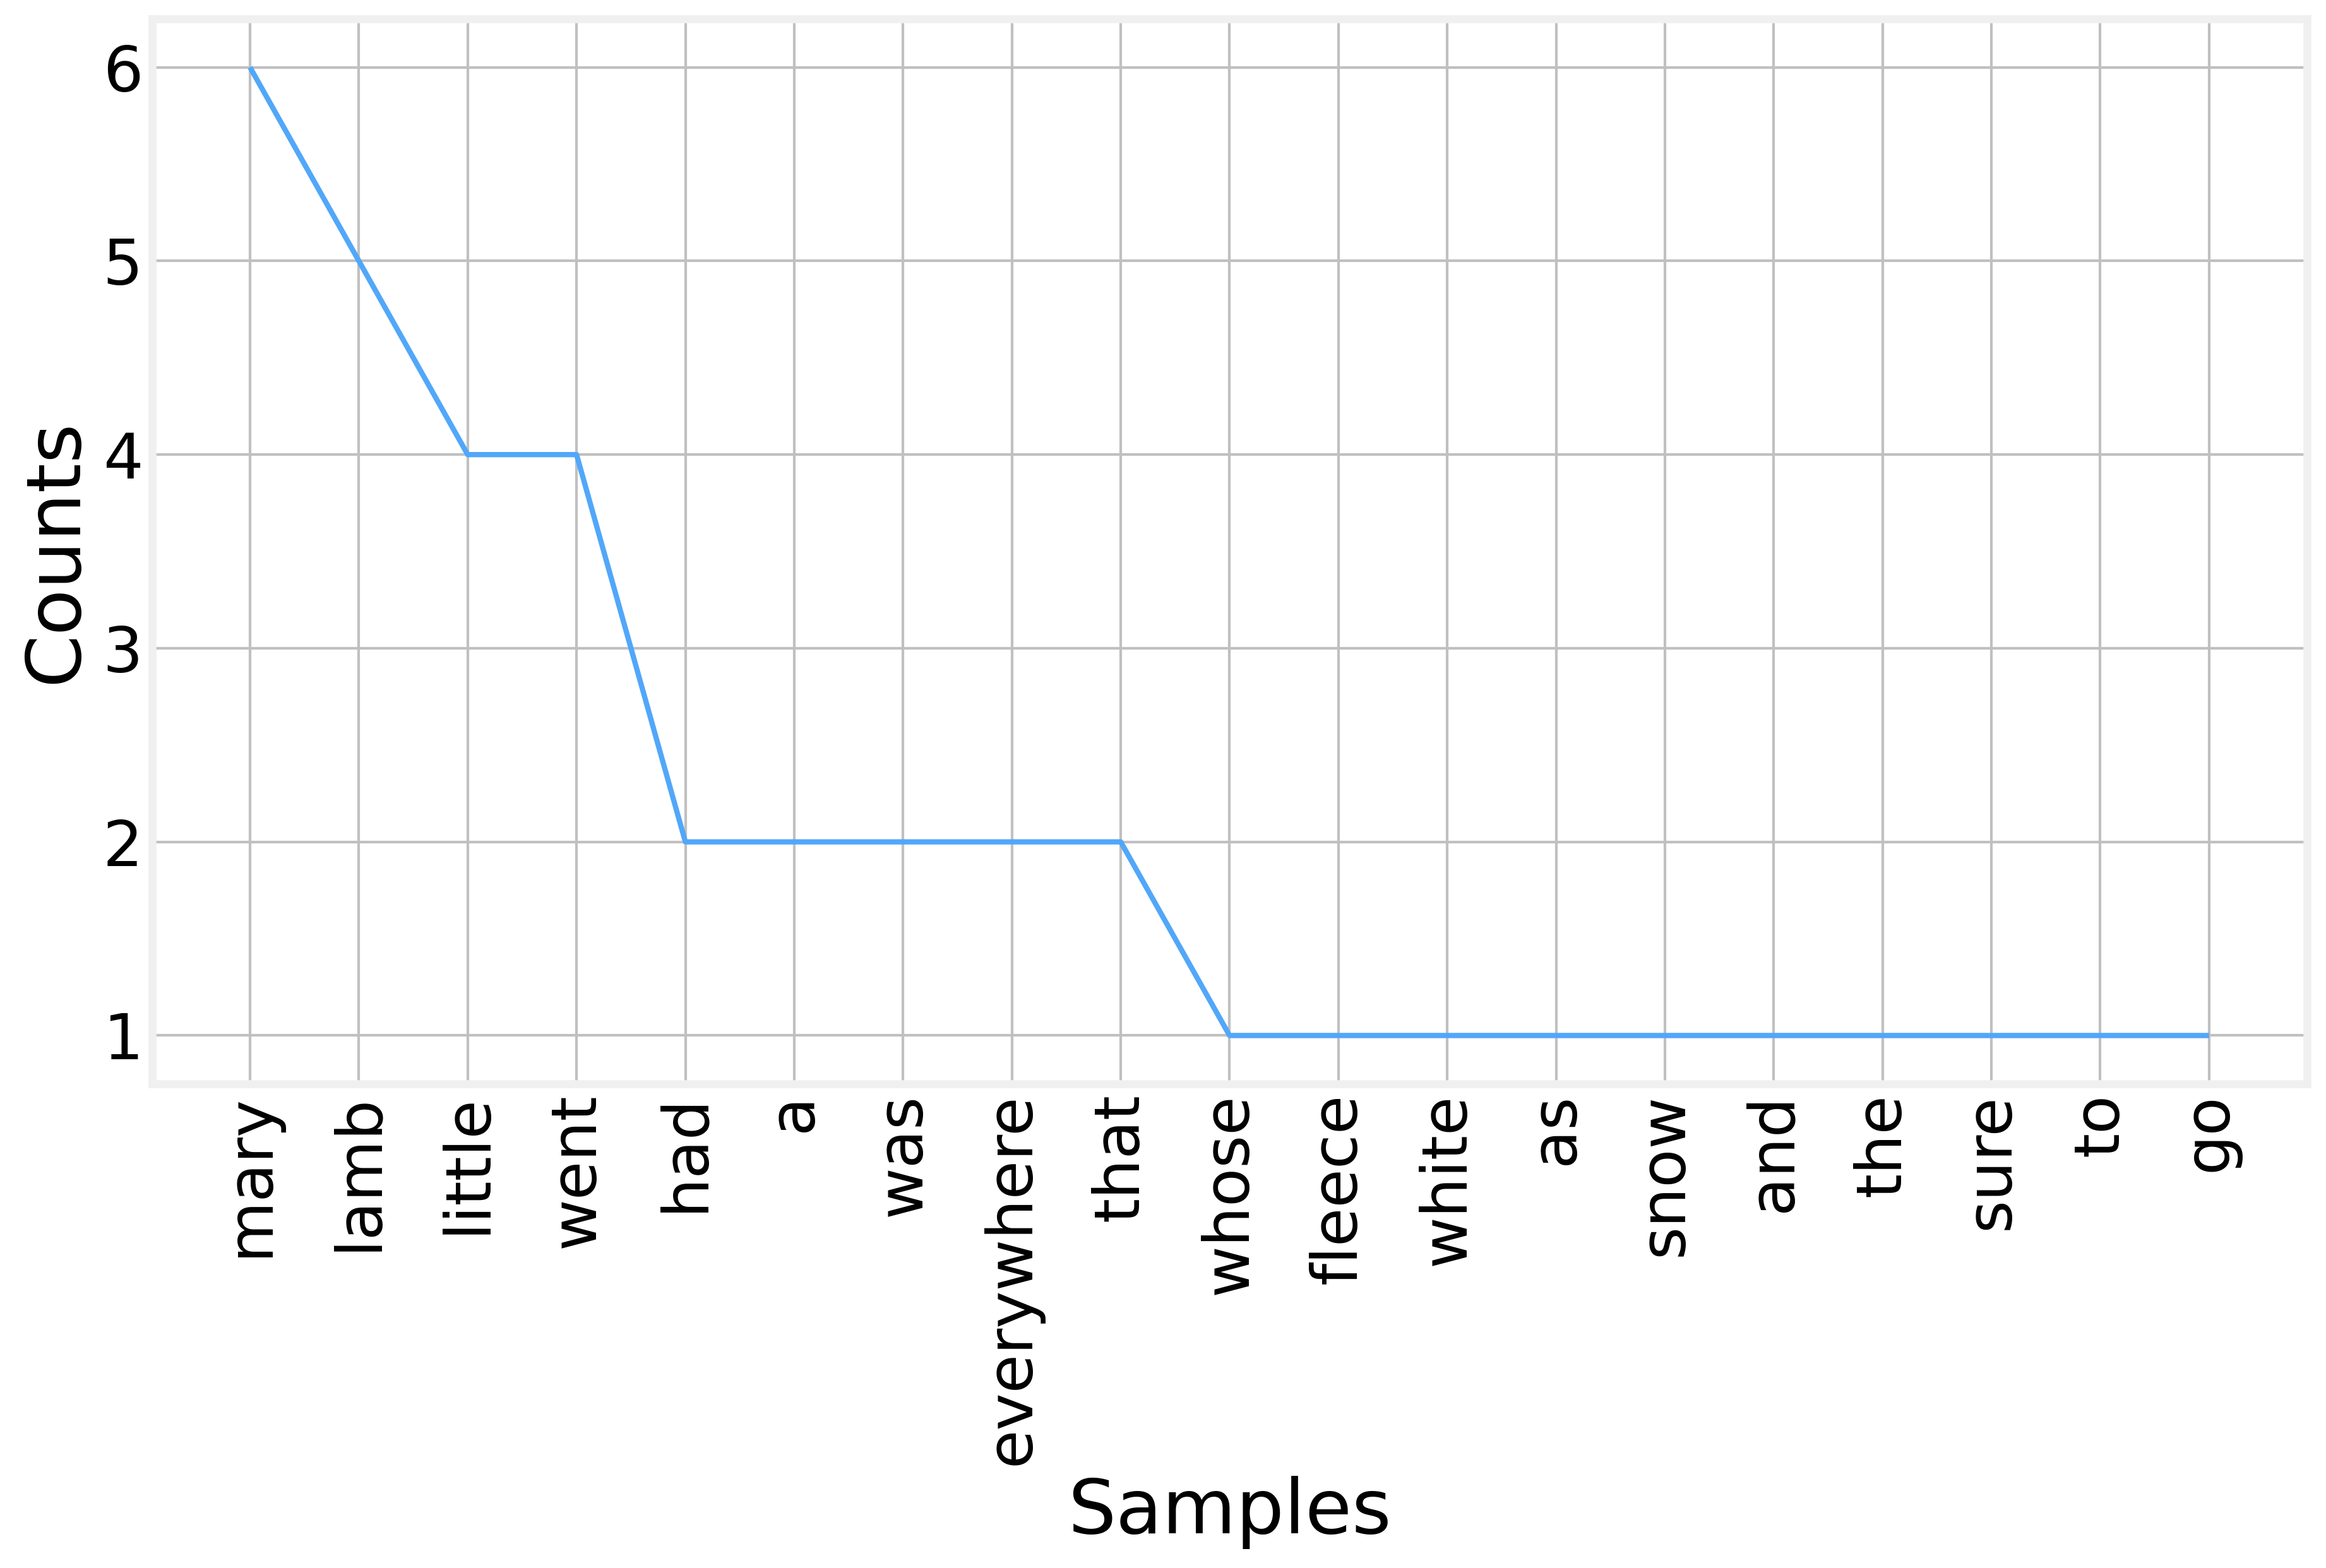

<Axes: xlabel='Samples', ylabel='Counts'>

In [34]:
nlp.plot()

Individual tf/idf scores, etc

In [35]:
nlp.tf_idf('snow', corpus[1])

0.12602676010180824

To get the full TF/IDF scores for our corpus, we do

In [36]:
TFIDF = []

for doc in corpus:
    current = {}
    for token in doc:
        current[token] = nlp.tf_idf(token, doc)
        
    TFIDF.append(current)

In [37]:
TFIDF

[{'mary': 0.0,
  'had': 0.07701635339554948,
  'a': 0.07701635339554948,
  'little': 0.23104906018664842,
  'lamb': 0.09589402415059362},
 {'mary': 0.0,
  'had': 0.06301338005090412,
  'a': 0.06301338005090412,
  'little': 0.06301338005090412,
  'lamb': 0.026152915677434625,
  'whose': 0.12602676010180824,
  'fleece': 0.12602676010180824,
  'was': 0.06301338005090412,
  'white': 0.12602676010180824,
  'as': 0.12602676010180824,
  'snow': 0.12602676010180824},
 {'and': 0.15403270679109896,
  'everywhere': 0.07701635339554948,
  'that': 0.07701635339554948,
  'mary': 0.0,
  'went': 0.23104906018664842},
 {'everywhere': 0.06931471805599453,
  'that': 0.06931471805599453,
  'mary': 0.0,
  'went': 0.06931471805599453,
  'the': 0.13862943611198905,
  'lamb': 0.028768207245178087,
  'was': 0.06931471805599453,
  'sure': 0.13862943611198905,
  'to': 0.13862943611198905,
  'go': 0.13862943611198905}]

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>